# Continuous control (Deep Reinforcement Learning Nanodegree)

## by José Manuel García López

## July 2nd 2020
In this notebook, the implementation of a DDPG is to be done in order to solve a Unity environment.

## 1. Start the Environment

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch

from collections import deque
from ddpg_agent import Agent, ReplayBuffer
from unityagents import UnityEnvironment

%matplotlib inline

# Load Reacher env with 20 agents
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## 3. Training the model

In [5]:
random_seed = 7
train_mode = True

agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)

In [7]:
def ddpg(n_episodes=2000, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    total_scores_deque = deque(maxlen=100)
    total_scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]   
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
        
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            
            dones = env_info.local_done
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            scores += env_info.rewards
            states = next_states
            
            if t%learn_every == 0:
                for _ in range(num_learn):
                    agent.start_learn()
            
            if np.any(dones):
                break
    
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)
        duration = time.time() - start_time
        
        print('\rEpisode {}\tTotal Average Score: {:.2f}\tMean: {:.2f}\tMin: {:.2f}\tMax: {:.2f}\tDuration: {:.2f}'
              .format(i_episode, total_average_score, mean_score, min_score, max_score, duration))

        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(i_episode, total_average_score))  
            
        if total_average_score >= goal_score and i_episode >= 100:
            print('Problem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, total_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return total_scores

scores = ddpg()

Episode 1	Total Average Score: 0.34	Mean: 0.34	Min: 0.34	Max: 0.34	Duration: 3.24


/home/workspace/ddpg_agent.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 2	Total Average Score: 0.38	Mean: 0.42	Min: 0.42	Max: 0.42	Duration: 23.44
Episode 3	Total Average Score: 0.66	Mean: 1.21	Min: 1.21	Max: 1.21	Duration: 25.58
Episode 4	Total Average Score: 0.74	Mean: 1.01	Min: 1.01	Max: 1.01	Duration: 24.68
Episode 5	Total Average Score: 0.86	Mean: 1.31	Min: 1.31	Max: 1.31	Duration: 25.35
Episode 6	Total Average Score: 0.71	Mean: 0.00	Min: 0.00	Max: 0.00	Duration: 33.96
Episode 7	Total Average Score: 0.65	Mean: 0.23	Min: 0.23	Max: 0.23	Duration: 28.05
Episode 8	Total Average Score: 0.69	Mean: 0.97	Min: 0.97	Max: 0.97	Duration: 23.03
Episode 9	Total Average Score: 0.69	Mean: 0.71	Min: 0.71	Max: 0.71	Duration: 21.86
Episode 10	Total Average Score: 0.73	Mean: 1.06	Min: 1.06	Max: 1.06	Duration: 22.57
Episode 10	Total Average Score: 0.73
Episode 11	Total Average Score: 0.75	Mean: 0.97	Min: 0.97	Max: 0.97	Duration: 22.48
Episode 12	Total Average Score: 0.77	Mean: 0.96	Min: 0.96	Max: 0.96	Duration: 22.44
Episode 13	Total Average Score: 0.86	Mean: 1.94

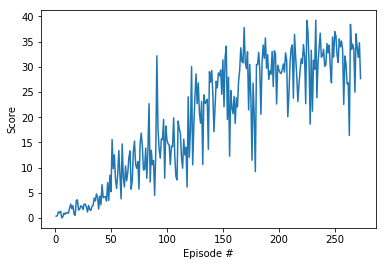

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
env.close()